In [2]:
%pip install scikit-surprise

import pandas as pd
import numpy as np
import random
from surprise import Dataset, Reader, SVD, NMF, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: still running...
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build scikit-surprise
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for scikit-surprise (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [155 lines of output]
      C:\Users\hp\AppData\Local\Temp\pip-build-env-jysid45r\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              *******************************************

ModuleNotFoundError: No module named 'surprise'

In [ ]:
path = "../data"
ratings = pd.read_csv(f"{path}/processed/ratings.csv")
movies  = pd.read_csv(f"{path}/processed/movies.csv")


In [25]:
#Train-Test Split (Random 80/20)

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
print("Train set size:", trainset.n_ratings)
print("Test set size:", len(testset))

Train set size: 79429
Test set size: 19858


In [4]:
# Random Recommender
def random_recommender(movies, n=5):
    return movies.sample(n)['title'].tolist()

print("🎲 Random Recommender Example:")
print(random_recommender(movies, n=5))

# Popularity Recommender (average rating)
movie_popularity = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_popularity = movie_popularity.merge(movies[['movieId', 'title']], on='movieId')
movie_popularity = movie_popularity.sort_values(by='rating', ascending=False)

def popularity_recommender(movie_popularity, n=5):
    return movie_popularity.head(n)['title'].tolist()

print("\n⭐ Popularity Recommender Example:")
print(popularity_recommender(movie_popularity, n=5))

🎲 Random Recommender Example:
['Butch Cassidy and the Sundance Kid (1969)', 'Two or Three Things I Know About Her (1966)', 'Body Snatcher, The (1945)', 'Vampire in Brooklyn (1995)', 'Men of Means (1998)']

⭐ Popularity Recommender Example:
['Pather Panchali (1955)', 'Close Shave, A (1995)', "Schindler's List (1993)", 'Wrong Trousers, The (1993)', 'Casablanca (1942)']


In [5]:
#Random Recommender Predictions for RMSE/MAE

pred_random = [(uid, iid, true_r, np.random.randint(1,6), None) for (uid, iid, true_r) in testset]
rmse_random = accuracy.rmse(pred_random)
mae_random  = accuracy.mae(pred_random)

RMSE: 1.8814
MAE:  1.5067


In [6]:
#Popularity Predictions for RMSE/MAE

movie_avg = ratings.groupby('movieId')['rating'].mean().to_dict()
pred_popular = [(uid, iid, true_r, movie_avg.get(iid, 3.0), None) for (uid, iid, true_r) in testset]
rmse_pop = accuracy.rmse(pred_popular)
mae_pop  = accuracy.mae(pred_popular)

RMSE: 0.9945
MAE:  0.7936


## Collaborative Filtering Models (User/Item KNN)

In [7]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate

# User-User KNN
user_knn = KNNBasic(sim_options={'user_based': True})
print("\n🔹 User-User KNN Cross-Validation:")
cross_validate(user_knn, data, measures=['RMSE','MAE'], cv=3, verbose=True)



🔹 User-User KNN Cross-Validation:
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9798  0.9846  0.9809  0.9817  0.0020  
MAE (testset)     0.7740  0.7793  0.7774  0.7769  0.0022  
Fit time          0.48    0.48    0.45    0.47    0.02    
Test time         5.13    5.97    4.65    5.25    0.54    


{'test_rmse': array([0.97981023, 0.98457269, 0.9808652 ]),
 'test_mae': array([0.77396657, 0.77926568, 0.77735329]),
 'fit_time': (0.48157787322998047, 0.48326802253723145, 0.44827985763549805),
 'test_time': (5.125553369522095, 5.965489625930786, 4.649183034896851)}

In [8]:
user_knn = KNNBasic(sim_options={'user_based': True})
cv_user = cross_validate(user_knn, data, measures=['RMSE','MAE'], cv=3, verbose=True)

rmse_user = np.mean(cv_user['test_rmse'])
mae_user  = np.mean(cv_user['test_mae'])


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9816  0.9797  0.9813  0.9809  0.0008  
MAE (testset)     0.7757  0.7767  0.7777  0.7767  0.0008  
Fit time          0.43    0.45    0.72    0.53    0.13    
Test time         4.53    5.10    7.09    5.57    1.09    


In [9]:
print(f"\nUser-KNN CV -> RMSE: {rmse_user:.4f}, MAE: {mae_user:.4f}")


User-KNN CV -> RMSE: 0.9809, MAE: 0.7767


In [10]:
# Item-Item KNN CV
# ---------------------------
item_knn = KNNBasic(sim_options={'user_based': False})
cv_item = cross_validate(item_knn, data, measures=['RMSE','MAE'], cv=3, verbose=True)

rmse_item = np.mean(cv_item['test_rmse'])
mae_item  = np.mean(cv_item['test_mae'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9819  0.9765  0.9885  0.9823  0.0049  
MAE (testset)     0.7778  0.7740  0.7838  0.7786  0.0040  
Fit time          0.57    0.61    0.56    0.58    0.02    
Test time         5.01    5.38    5.29    5.23    0.16    


In [11]:

print(f"Item-KNN CV -> RMSE: {rmse_item:.4f}, MAE: {mae_item:.4f}")

Item-KNN CV -> RMSE: 0.9823, MAE: 0.7786


## Matrix Factorization Models

In [12]:
#svd
svd_model = SVD()
svd_model.fit(trainset)
predictions_svd = svd_model.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd  = accuracy.mae(predictions_svd)

RMSE: 0.9271
MAE:  0.7322


In [13]:
# --- NMF ---
nmf_model = NMF()
nmf_model.fit(trainset)
predictions_nmf = nmf_model.test(testset)
rmse_nmf = accuracy.rmse(predictions_nmf)
mae_nmf  = accuracy.mae(predictions_nmf)

RMSE: 0.9488
MAE:  0.7487


 # Precision@K Function

In [14]:
def precision_recall_at_k(predictions, k=10, threshold=4):
    """Compute Precision@K and Recall@K for each user"""
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in top_k)

        if n_rel != 0:
            precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)
            recalls.append(n_rel_and_rec_k / n_rel)

    return np.mean(precisions), np.mean(recalls)

# Precision@10 for SVD
prec_svd, rec_svd = precision_recall_at_k(predictions_svd, k=10, threshold=4)
print(f"\nSVD Precision@10: {prec_svd:.4f}, Recall@10: {rec_svd:.4f}")




SVD Precision@10: 0.6334, Recall@10: 0.2910


In [15]:
# Precision@10 for NMF
prec_nmf, rec_nmf = precision_recall_at_k(predictions_nmf, k=10, threshold=4)
print(f"NMF Precision@10: {prec_nmf:.4f}, Recall@10: {rec_nmf:.4f}")

NMF Precision@10: 0.6114, Recall@10: 0.2847


## Visualizations

In [18]:
sns.set(style="whitegrid")

models = ['Random', 'Popularity', 'User-KNN', 'Item-KNN', 'SVD', 'NMF']
rmse_values = [rmse_random, rmse_pop, rmse_user, rmse_item, rmse_svd, rmse_nmf]
mae_values  = [mae_random, mae_pop, mae_user, mae_item, mae_svd, mae_nmf]
precision_10 = [0, 0, 0, 0, prec_svd, prec_nmf]
recall_10    = [0, 0, 0, 0, rec_svd, rec_nmf]

C:\Users\Ranajit Hazra\AppData\Local\Temp\ipykernel_16032\1420700754.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_values, palette='viridis')


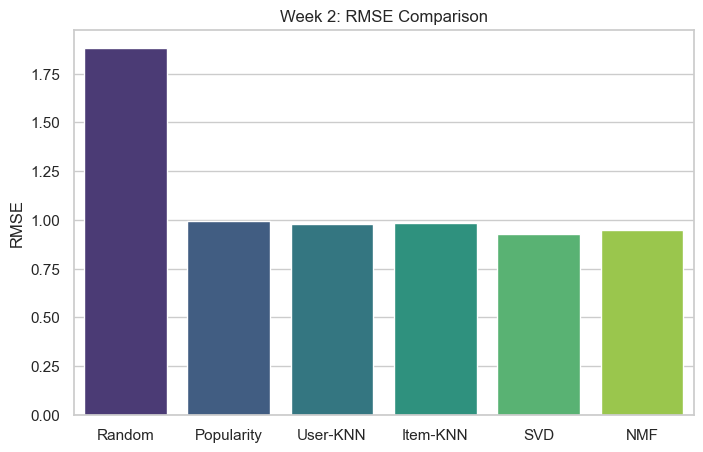

In [21]:
# RMSE
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=rmse_values, palette='viridis')
plt.title("Week 2: RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

C:\Users\Ranajit Hazra\AppData\Local\Temp\ipykernel_16032\2654522117.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_values, palette='magma')


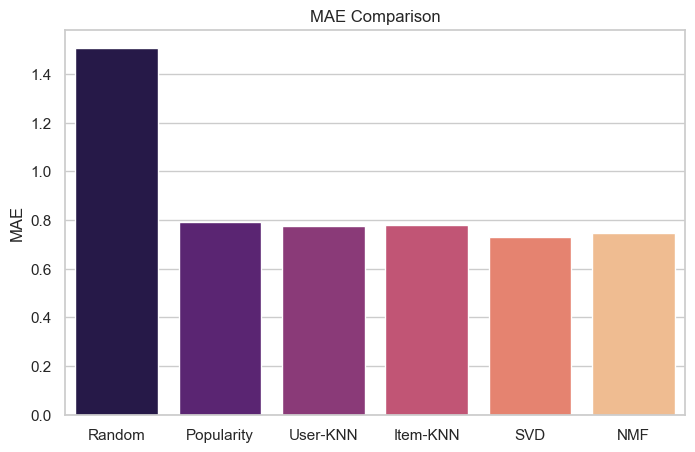

In [22]:
# MAE
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=mae_values, palette='magma')
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.show()

C:\Users\Ranajit Hazra\AppData\Local\Temp\ipykernel_16032\4143649324.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=precision_10, palette='coolwarm')


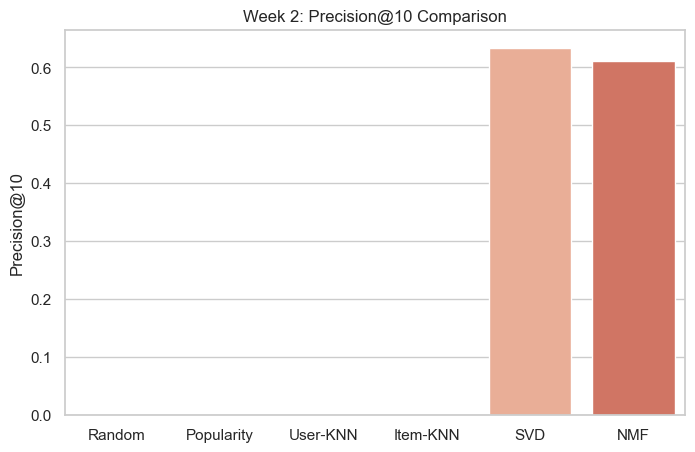

In [23]:
# Precision@10
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=precision_10, palette='coolwarm')
plt.title("Week 2: Precision@10 Comparison")
plt.ylabel("Precision@10")
plt.show()

C:\Users\Ranajit Hazra\AppData\Local\Temp\ipykernel_16032\340862355.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=recall_10, palette='cubehelix')


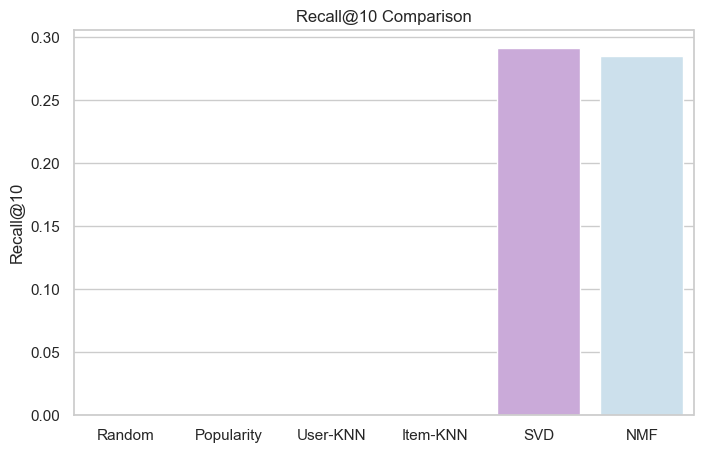

In [24]:
# Recall@10
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=recall_10, palette='cubehelix')
plt.title("Recall@10 Comparison")
plt.ylabel("Recall@10")
plt.show()